## Datashading a 2.7-billion-point Open Street Map database

Most [datashader](https://github.com/bokeh/datashader) examples use "medium-sized" datasets, because they need to be small enough to be distributed over the internet without racking up huge bandwidth charges for the project maintainers. Even though these datasets can be relatively large (such as the [1-billion point Open Street Map example](https://anaconda.org/jbednar/osm-1billion)), they still fit into memory on a 16GB laptop.

Because Datashader supports [Dask](http://dask.pydata.org) dataframes, it also works well with truly large datasets, much bigger than will fit in any one machine's physical memory. On a single machine, Dask will automatically and efficiently page in the data as needed, and you can also easily distribute the data and computation across multiple machines. Here we illustrate how to work "out of core" on a single machine using a 22GB OSM dataset containing 2.7 billion points.

The data is taken from Open Street Map's (OSM) [bulk GPS point data](https://blog.openstreetmap.org/2012/04/01/bulk-gps-point-data/), and is unfortunately too large to distribute with Datashader (8.4GB compressed). The data was collected by OSM contributors' GPS devices, and was provided as a CSV file of `latitude,longitude` coordinates. The data was downloaded from their website, extracted, converted to use positions in Web Mercator format using `datashader.utils.lnglat_to_meters()`, sorted using [spacial indexing](http://datashader.org/user_guide/2_Points.html#Spatial-indexing), and then stored in a [parquet](https://github.com/dask/fastparquet) file for [fast partition-based access](https://github.com/bokeh/datashader/issues/129#issuecomment-300515690). To run this notebook, you would need to do the same process yourself to obtain `osm-3billion.parq`.   Once you have it, you can follow the steps below to load and plot the data.

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import dask.diagnostics as diag

from datashader import spatial
from datashader.geo import lnglat_to_meters

In [2]:
%%time
df = spatial.read_parquet('./data/osm-3billion.parq')

CPU times: user 1.35 s, sys: 20.9 ms, total: 1.37 s
Wall time: 1.38 s


In [3]:
df.head()

x           y
0 -17219646.0 -19219556.0
1 -17382392.0 -18914976.0
2 -16274360.0 -17538778.0
3 -17219646.0 -16627029.0
4 -16408889.0 -16618700.0

### Aggregation

First, we define some spatial regions of interest and create a canvas to provide pixel-shaped bins in which points can be aggregated:

In [4]:
def bounds(x_range, y_range):
    x,y = lnglat_to_meters(x_range, y_range)
    return dict(x_range=x, y_range=y)

Earth       = ((-180.00, 180.00), (-59.00, 74.00))
France      = (( -12.00,  16.00), ( 41.26, 51.27))
Paris       = ((   2.05,   2.65), ( 48.76, 48.97))

plot_width = 1000
plot_height = int(plot_width*0.5)

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds(*Earth))

Next we aggregate the data to produce a fixed-size aggregate array.  This process may take up to a minute, so we provide a progress bar using dask:

In [5]:
with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
    agg = cvs.points(df, 'x', 'y')

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed | 30.8s


We can now visualize this data very quickly, ignoring low-count noise as described in the [1-billion point OSM version](https://anaconda.org/jbednar/osm-1billion):

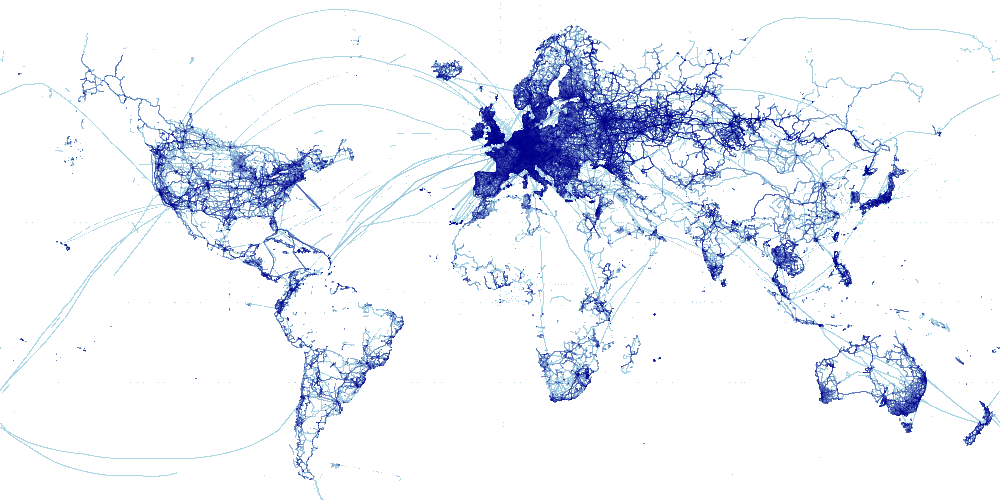

In [6]:
tf.shade(agg.where(agg > 15), cmap=["lightblue", "darkblue"])

Looking at smaller areas is much quicker, thanks to SpatialPointsFrame:

In [7]:
def plot(x_range, y_range):
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds(x_range, y_range))
    agg = cvs.points(df, 'x', 'y')
    return tf.shade(agg, cmap=["lightblue","darkblue"])

CPU times: user 39.1 s, sys: 12.5 s, total: 51.7 s
Wall time: 12.6 s


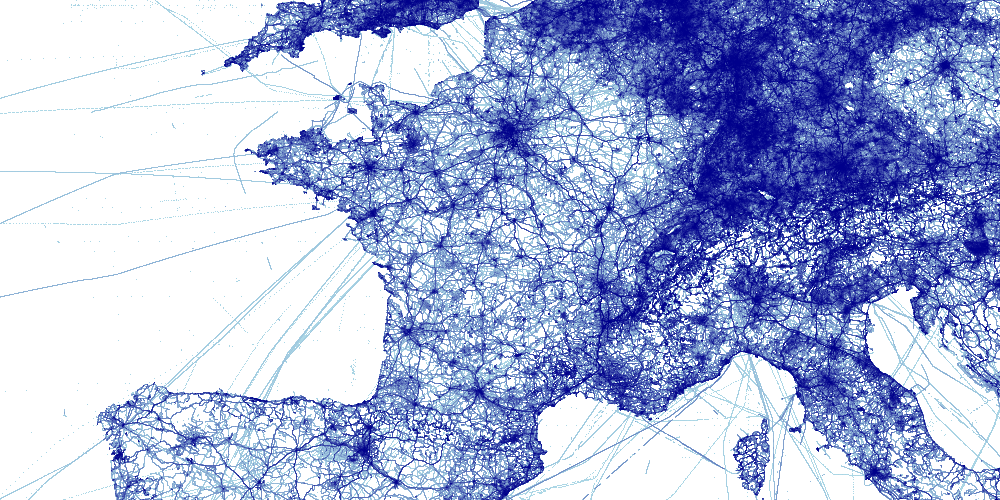

In [8]:
%time plot(*France)

CPU times: user 432 ms, sys: 164 ms, total: 595 ms
Wall time: 447 ms


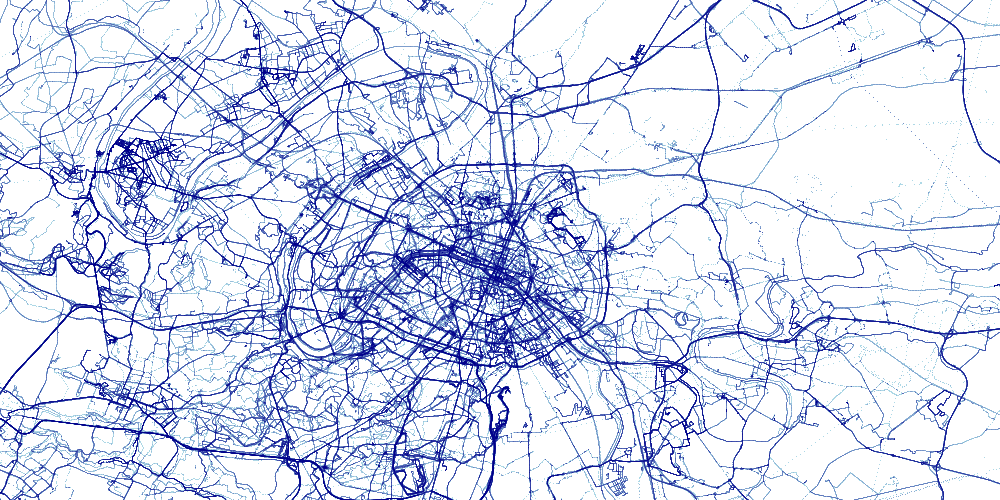

In [9]:
%time plot(*Paris)

### Performance Profile

Dask offers some tools to visualize how memory and processing power are being used during these calculations:

In [10]:
from bokeh.io import output_notebook
from bokeh.resources import CDN
output_notebook(CDN, hide_banner=True)

In [11]:
diag.visualize([prof, rprof]);

Performance notes:
- On a 16GB machine, most of the time is spent reading the data from disk (the purple rectangles)
- Reading time includes not just disk I/O, but decompressing chunks of data
- The disk reads don't release the [Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock) (GIL), and so CPU usage (see second chart above) drops to only one core during those periods.
- During the aggregation steps (the green rectangles), CPU usage on this machine with 8 hyperthreaded cores (4 full cores) spikes to nearly 700%, because the aggregation function is implemented in parallel. 
- The data takes up 22 GB uncompressed, but only a peak of around 6 GB of physical memory is ever used because the data is paged in as needed.